In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Functions and Derivatives

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

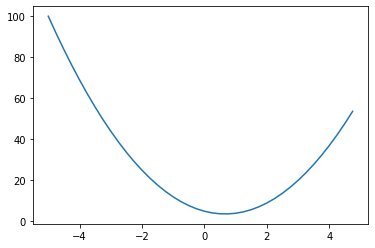

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [6]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Engine

In [207]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
       
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
        
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers currently"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        
        out._backward = _backward
        
        return out
    
    def __truediv__(self,other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
                        
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
a = Value(2.0,label ='a')    
b = Value(-3.0,label ='b')   
c = Value(10.0,label ='c')
e = a*b; e.label = 'e'
d = e + c; d.label ='d'
f = Value(-2.0, label= 'f')
L = d*f; L.label = 'L'
L.grad = 1
L

Value(data=-8.0)

In [101]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [102]:
d._op

'+'

In [132]:
a = Value(1.0, label='a')
a + 1
2 + a

Value(data=3.0)

In [103]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data%.4f | grad%.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

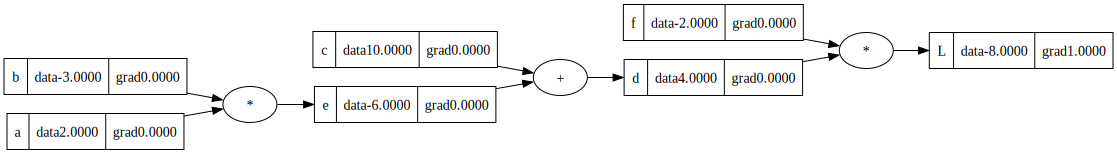

In [104]:
draw_dot(L)

Gradient Calculation

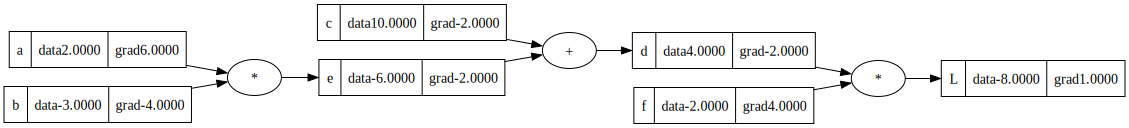

In [90]:
f.grad = d.data
d.grad = f.data
c.grad = 1*d.grad # DL/Dc = Dd/dc*DL/Dd
e.grad = 1*d.grad # DL/De = Dd/de*DL/Dd
a.grad = b.data*e.grad # DL/Da = De/Da*DL/De
b.grad = a.data*e.grad # DL/Db = De/Db*Dl/De
draw_dot(L)

Update

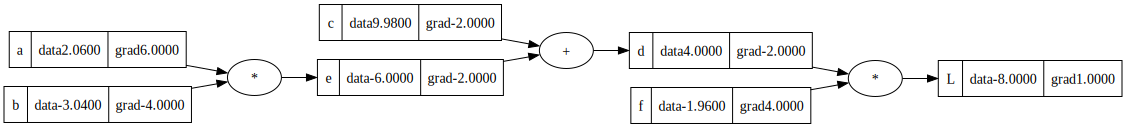

In [91]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

draw_dot(L)

 Building a Neural Network

In [116]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label ='x1*w1'
x2w2 = x2*w2; x2w2.label ='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();  o.label = 'o'

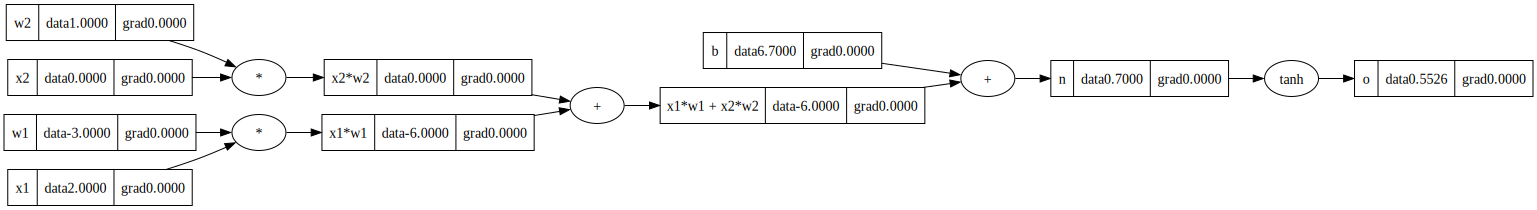

In [117]:
draw_dot(o)

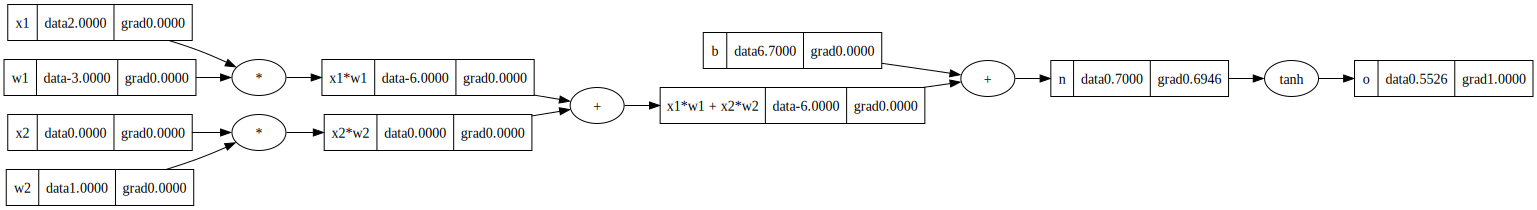

In [107]:
o.grad = 1.0
o._backward()
draw_dot(o)

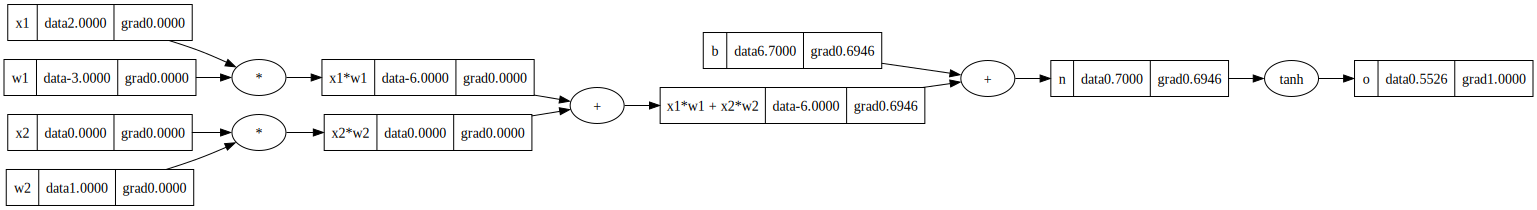

In [108]:
n._backward()
draw_dot(o)
# x1w1x2w2.grad = 1.0*n.grad
# b.grad = 1.0*n.grad
# x1w1.grad = 1.0*x1w1x2w2.grad
# x2w2.grad = 1.0*x1w1x2w2.grad

# x1.grad = w1.data *x1w1.grad
# x2.grad = w2.data *x2w2.grad
# w1.grad = x1.data *x1w1.grad
# w2.grad = x2.data *x2w2.grad

# draw_dot(o)

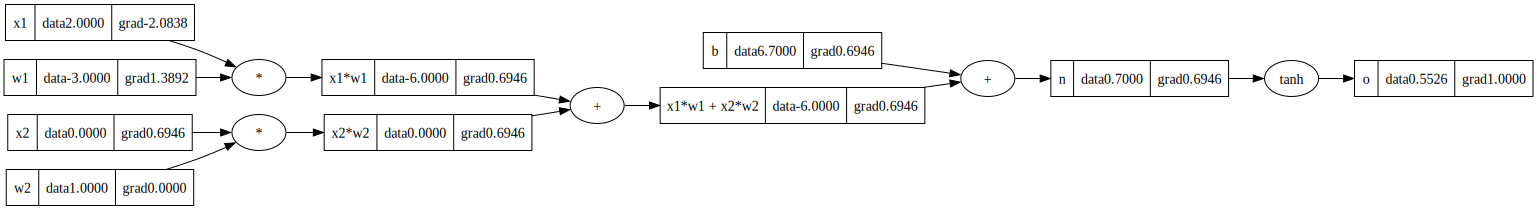

In [109]:
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

Topological ordered graph

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.7),
 Value(data=0.7000000000000002),
 Value(data=0.5526325195849595)]

Implementing backprop

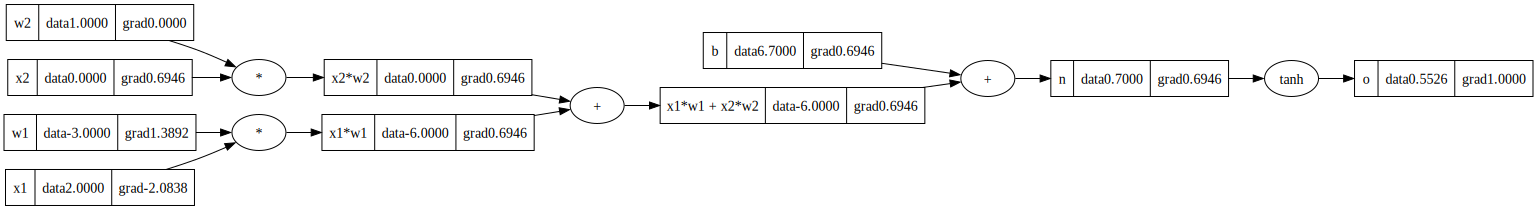

In [118]:
# o.grad = 1.0
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)
# topo
# for node in reversed(topo):
#     node._backward()
    
o.backward()

draw_dot(o)    

Test: Accumulation of gradients

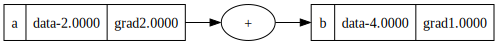

In [122]:
a = Value(-2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

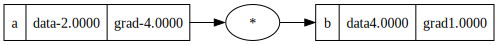

In [125]:
a = Value(-2.0, label='a')
b = a * a; b.label = 'b'
b.backward()
draw_dot(b)

PyTorch

In [137]:
import torch

In [141]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735890195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w2.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 0.0


Implementing a Neural Network using the engine

In [217]:
import random 

class Neuron:   
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in  range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
#         print(act)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.42347357002721747)

Example data

In [218]:
xs = [[2.0, 3.0, -1.0],
     [3.0, -1.0, 0.5],
     [0.5, 1.0, 1.0],
     [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.42347357002721747),
 Value(data=0.4910962802580729),
 Value(data=0.5566841794005123),
 Value(data=0.5164583881083157)]

In [220]:
len(n.parameters())

41

In [221]:
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.212828966283278)

Forward pass

In [227]:
ypred = [n(x) for x in xs]
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.0047756693106455)

Backward pass

In [222]:
loss.backward()

Update

In [225]:
for p in n.parameters():
    p.data += -0.01*p.grad

Training loop

In [230]:
for k in range(10):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    
    
    #zero grad
    for p in n.parameters():
        p.grad = 0.0
        
    #backward pass
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.01*p.grad
        
    print('iter:',k, ', loss:' ,loss.data)


iter: 0 , loss: 1.9899625838119013
iter: 1 , loss: 1.7815864637957153
iter: 2 , loss: 1.5789444207889909
iter: 3 , loss: 1.389697327250408
iter: 4 , loss: 1.2188776528826346
iter: 5 , loss: 1.068693774204355
iter: 6 , loss: 0.9390922559170123
iter: 7 , loss: 0.8285636228418306
iter: 8 , loss: 0.7348756917231485
iter: 9 , loss: 0.6556005031761472
